# Classificando texto com LSTMs (Spam Detection)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import Input, Embedding, LSTM, GlobalMaxPooling1D, Dense
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model

In [2]:
# Lendo os dados
df = pd.read_csv('spam_data.csv', encoding='ISO-8859-1')

df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


# Tratamento dos dados

In [3]:
# Dropando as colunas desnecessárias
df = df.drop(["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"], axis=1)

df.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [4]:
# Renomeando as colunas
df.columns = ['labels', 'data']

df.head()

,labels,data
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [5]:
# Transformando os labels em valores binários
df['labels'] = df['labels'].map({'ham': 0, 'spam': 1})

df.head()

,labels,data
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


# Pré-processamento para a modelagem

In [6]:
# Splitando os dados em treinamento e teste
Y = df['labels'].values
x_train, x_test, y_train, y_test = train_test_split(df['data'], Y, test_size=0.33)

In [7]:
# Transformando as frases em sequências (TOKENIZATION)
MAX_VOCAB_SIZE = 20000

tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(x_train)

sequences_train = tokenizer.texts_to_sequences(x_train)
sequences_test = tokenizer.texts_to_sequences(x_test)

In [8]:
# Quantas palavras (TOKENS) temos no vocabulário?
word_index = tokenizer.word_index
n_words = len(word_index)
print("Temos %s tokens únicos." % n_words)

Temos 7299 tokens únicos.


In [9]:
# Padding dos dados de treinamento
df_train = pad_sequences(sequences_train)
print("Dimensões do vetor de dados de treinamento:", df_train.shape) # 3733 palavras, maior frase tem 189 palavras.
                                                                     # N x T array.

# Tamanho da sequência
T = df_train.shape[1]

Dimensões do vetor de dados de treinamento: (3733, 162)


In [10]:
# Padding dos dados de teste
df_test = pad_sequences(sequences_test, maxlen=T) # Definindo o valor máximo das frases como 189, o valor máximo
                                                  # encontrado nos dados de treinamento.
    
print("Dimensões do vetor de dados de teste:", df_test.shape)

Dimensões do vetor de dados de teste: (1839, 162)


# Modelagem

In [11]:
# Criando o modelo

# Dimensionalidade da Embedding Layer
# Obs.: Lembrando que, queremos que o tamanho da Embedding Layer seja (n_words + 1) x D, 
# pois sabemos que o primeiro índice do word_index começa em 1, e não em 0.
D = 20

# Dimensionalidade da Recurrent Layer (hidden state)
M = 15

i = Input(shape=(T,))
x = Embedding(n_words + 1, D)(i)
x = LSTM(M, return_sequences=True)(x)
x = GlobalMaxPooling1D()(x) # Funciona bem para aprender long-term dependencies (return_sequences=True e GlobalMaxPool)
x = Dense(1, activation='sigmoid')(x)

model = Model(i, x)

In [12]:
# Compilando o modelo
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Treinando o modelo
print("Treinando o modelo...")
r = model.fit(df_train, y_train, epochs=10, validation_data=(df_test, y_test))

Treinando o modelo...
Train on 3733 samples, validate on 1839 samples
Epoch 1/10
3733/3733 [==============================] - 6s 2ms/sample - loss: 0.4925 - accuracy: 0.8521 - val_loss: 0.3861 - val_accuracy: 0.8695
Epoch 2/10
3733/3733 [==============================] - 2s 633us/sample - loss: 0.3922 - accuracy: 0.8642 - val_loss: 0.3778 - val_accuracy: 0.8695
Epoch 3/10
3733/3733 [==============================] - 2s 640us/sample - loss: 0.3662 - accuracy: 0.8642 - val_loss: 0.3146 - val_accuracy: 0.8695
Epoch 4/10
3733/3733 [==============================] - 2s 637us/sample - loss: 0.2358 - accuracy: 0.8811 - val_loss: 0.1792 - val_accuracy: 0.9527
Epoch 5/10
3733/3733 [==============================] - 2s 632us/sample - loss: 0.1381 - accuracy: 0.9821 - val_loss: 0.1306 - val_accuracy: 0.9734
Epoch 6/10
3733/3733 [==============================] - 2s 640us/sample - loss: 0.0850 - accuracy: 0.9890 - val_loss: 0.0890 - val_accuracy: 0.9810
Epoch 7/10
3733/3733 [======================

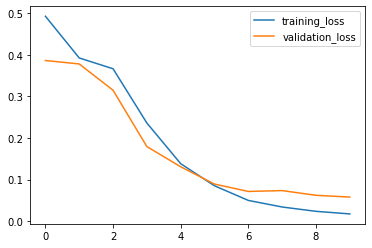

In [13]:
# Plotando a loss por iteração
plt.plot(r.history['loss'], label='training_loss')
plt.plot(r.history['val_loss'], label='validation_loss')
plt.legend()

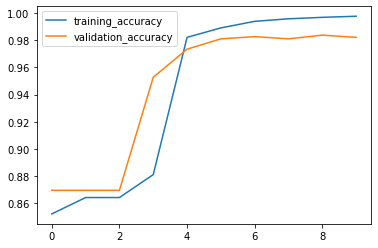

In [14]:
# Plotando a acurácia por iteração
plt.plot(r.history['accuracy'], label='training_accuracy')
plt.plot(r.history['val_accuracy'], label='validation_accuracy')
plt.legend()